In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from sklearn.model_selection import KFold
from PIL import Image
from crossvit import CrossViT
import os

In [8]:
train_transform_rgb = T.Compose([...])
train_transform_thermal = T.Compose([...])


In [16]:
# --- 1. DATASET MODIFICATION ---
class WildfireDataset(Dataset):
    def __init__(self, root_dir, transform_rgb=None, transform_thermal=None):
        self.samples = []
        self.transform_rgb = transform_rgb
        self.transform_thermal = transform_thermal
        classes = {'Fire': 1, 'No Fire': 0}
        for cls, lbl in classes.items():
            rgb_dir     = os.path.join(root_dir, cls, 'RGB')
            thermal_dir = os.path.join(root_dir, cls, 'Thermal')
            if os.path.isdir(rgb_dir) and os.path.isdir(thermal_dir):
                for fname in os.listdir(rgb_dir):
                    if fname.lower().endswith(('.jpg','png','jpeg','tiff')):
                        r = os.path.join(rgb_dir, fname)
                        t = os.path.join(thermal_dir, fname)
                        if os.path.exists(t):
                            self.samples.append((r, t, lbl))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, i):
        rpath, tpath, lbl = self.samples[i]
        rgb     = Image.open(rpath).convert('RGB')
        thermal = Image.open(tpath).convert('L')
        if self.transform_rgb:     rgb     = self.transform_rgb(rgb)
        if self.transform_thermal: thermal = self.transform_thermal(thermal)
        return rgb, thermal, lbl

In [18]:
from torchvision import transforms as T
from torch.utils.data import DataLoader
import torch

# --- 1. Define your transforms (no ellipsis!) ---
train_transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

train_transform_thermal = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),  # single‑channel thermal
])

# --- 2. Instantiate your dataset and loader ---
train_ds = WildfireDataset(
    'D:/SEM 2 ASU/CSE 572 DATA MINING/Data_split/train',
    transform_rgb=train_transform_rgb,
    transform_thermal=train_transform_thermal
)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

In [20]:
class LateFusionModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # import your early‑fusion backbone but adapt channels
        self.rgb_net     = CrossViT(image_size=224, channels=3, num_classes=num_classes)
        self.thermal_net = CrossViT(image_size=224, channels=1, num_classes=num_classes)
        # fusion head: from 2×logit_size → final logits
        self.fuse = nn.Linear(num_classes*2, num_classes)
    
    def forward(self, rgb, thermal):
        # each branch returns [B, num_classes]
        out_rgb = self.rgb_net(rgb)
        out_th  = self.thermal_net(thermal)
        # concat and fuse
        cat = torch.cat([out_rgb, out_th], dim=1)    # [B, 2*num_classes]
        return self.fuse(cat)                        # [B, num_classes]



### 🔁 Cross-Validation Training for Late Fusion Network

This section performs **5-fold cross-validation** on the Late Fusion model. The model takes RGB and thermal image pairs as input, fuses features via a dual-stream CNN architecture, and predicts binary fire classifications.

Steps:
1. Splits the full training dataset into 5 folds using `KFold`.
2. Trains the model for 5 epochs on each fold using the `LateFusionModel`.
3. Stores per-epoch train and validation accuracy/loss for each fold.



=== Fold 1 ===
Epoch 1: Train Loss=0.1699, Acc=95.73% | Val Loss=0.2532, Acc=90.14%
Epoch 2: Train Loss=0.0572, Acc=97.51% | Val Loss=0.0158, Acc=100.00%
Epoch 3: Train Loss=0.0615, Acc=97.86% | Val Loss=0.0746, Acc=97.18%
Epoch 4: Train Loss=0.0628, Acc=96.80% | Val Loss=0.0202, Acc=100.00%
Epoch 5: Train Loss=0.0477, Acc=98.22% | Val Loss=0.0249, Acc=98.59%

=== Fold 2 ===
Epoch 1: Train Loss=0.1749, Acc=94.66% | Val Loss=0.0869, Acc=97.18%
Epoch 2: Train Loss=0.1393, Acc=96.09% | Val Loss=0.2352, Acc=90.14%
Epoch 3: Train Loss=0.0846, Acc=96.80% | Val Loss=0.1184, Acc=97.18%
Epoch 4: Train Loss=0.0689, Acc=98.22% | Val Loss=0.0379, Acc=98.59%
Epoch 5: Train Loss=0.0552, Acc=97.86% | Val Loss=0.0467, Acc=98.59%

=== Fold 3 ===
Epoch 1: Train Loss=0.2347, Acc=90.07% | Val Loss=0.2021, Acc=90.00%
Epoch 2: Train Loss=0.0849, Acc=97.52% | Val Loss=0.0647, Acc=98.57%
Epoch 3: Train Loss=0.0573, Acc=98.58% | Val Loss=0.0388, Acc=98.57%
Epoch 4: Train Loss=0.1071, Acc=95.74% | Val Loss=0.1

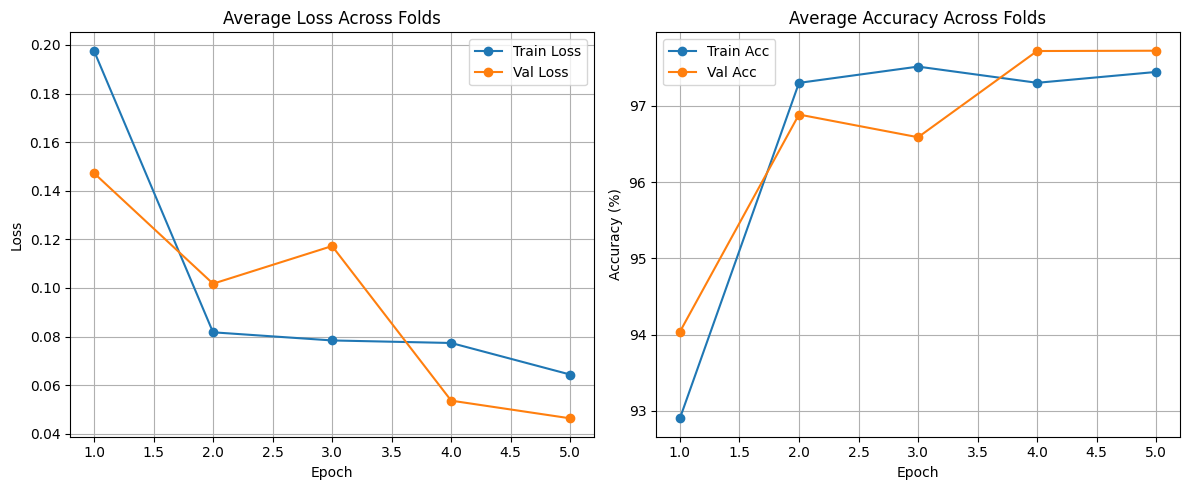

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# --- assume WildfireDataset, train_transform_rgb, train_transform_thermal,
#     LateFusionModel, and device are already defined above ---

# 1. Prepare dataset and CV
full_ds    = WildfireDataset(
    'D:/SEM 2 ASU/CSE 572 DATA MINING/Data_split/train',
    transform_rgb=train_transform_rgb,
    transform_thermal=train_transform_thermal
)
kf         = KFold(n_splits=5, shuffle=True, random_state=42)
num_epochs = 5
batch_size = 8

# 2. Storage for all folds
all_train_losses = []
all_val_losses   = []
all_train_accs   = []
all_val_accs     = []

# 3. Cross‐validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(full_ds), 1):
    print(f"\n=== Fold {fold} ===")
    train_loader = DataLoader(Subset(full_ds, train_idx),
                              batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(full_ds, val_idx),
                              batch_size=batch_size, shuffle=False)
    
    model     = LateFusionModel(num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    crit      = nn.CrossEntropyLoss()
    
    # per‐epoch lists for this fold
    train_losses = []
    val_losses   = []
    train_accs   = []
    val_accs     = []
    
    for epoch in range(1, num_epochs+1):
        # --- training ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for rgb, thermal, lbl in train_loader:
            rgb, thermal, lbl = rgb.to(device), thermal.to(device), lbl.to(device)
            optimizer.zero_grad()
            logits = model(rgb, thermal)
            loss   = crit(logits, lbl)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * lbl.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == lbl).sum().item()
            total   += lbl.size(0)
        
        train_loss = running_loss/total
        train_acc  = 100*correct/total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # --- validation ---
        model.eval()
        v_loss, v_corr, v_tot = 0.0, 0, 0
        with torch.no_grad():
            for rgb, thermal, lbl in val_loader:
                rgb, thermal, lbl = rgb.to(device), thermal.to(device), lbl.to(device)
                logits = model(rgb, thermal)
                loss   = crit(logits, lbl)
                v_loss  += loss.item() * lbl.size(0)
                v_corr  += (logits.argmax(1) == lbl).sum().item()
                v_tot   += lbl.size(0)
        
        val_loss = v_loss/v_tot
        val_acc  = 100*v_corr/v_tot
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.2f}% | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    
    # collect fold history
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

# 4. Average across folds
epochs = np.arange(1, num_epochs+1)
avg_train_loss = np.mean(all_train_losses, axis=0)
avg_val_loss   = np.mean(all_val_losses,   axis=0)
avg_train_acc  = np.mean(all_train_accs,   axis=0)
avg_val_acc    = np.mean(all_val_accs,     axis=0)

# 5. Plot
plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(epochs, avg_train_loss, marker='o', label='Train Loss')
plt.plot(epochs, avg_val_loss,   marker='o', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Average Loss Across Folds')
plt.legend(); plt.grid(True)

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(epochs, avg_train_acc, marker='o', label='Train Acc')
plt.plot(epochs, avg_val_acc,   marker='o', label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.title('Average Accuracy Across Folds')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()



### 📊 Per-Epoch Averaging Across Folds

This section calculates the **average training and validation accuracy/loss per epoch** by aggregating results from all 5 folds. This helps analyze the learning trends across the training process.


In [50]:
import numpy as np

# all_train_losses, all_val_losses, all_train_accs, all_val_accs
# are lists of length n_folds, each containing lists of length n_epochs.

# 1. Compute per‑epoch averages
avg_train_loss = np.mean(all_train_losses, axis=0)  # shape: [n_epochs]
avg_val_loss   = np.mean(all_val_losses,   axis=0)
avg_train_acc  = np.mean(all_train_accs,   axis=0)
avg_val_acc    = np.mean(all_val_accs,     axis=0)

# 2. Print them epoch by epoch
for epoch, (tl, vl, ta, va) in enumerate(zip(
        avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc
    ), start=1):
    print(f"Epoch {epoch:2d} — "
          f"Train Loss: {tl:.4f}, Val Loss: {vl:.4f}, "
          f"Train Acc: {ta:.2f}%, Val Acc: {va:.2f}%")


Epoch  1 — Train Loss: 0.1976, Val Loss: 0.1473, Train Acc: 92.90%, Val Acc: 94.04%
Epoch  2 — Train Loss: 0.0818, Val Loss: 0.1018, Train Acc: 97.30%, Val Acc: 96.89%
Epoch  3 — Train Loss: 0.0784, Val Loss: 0.1172, Train Acc: 97.51%, Val Acc: 96.59%
Epoch  4 — Train Loss: 0.0774, Val Loss: 0.0536, Train Acc: 97.30%, Val Acc: 97.72%
Epoch  5 — Train Loss: 0.0644, Val Loss: 0.0464, Train Acc: 97.44%, Val Acc: 97.72%



### ✅ Final Epoch and Overall Performance Metrics

Here, we compute:
- Final epoch averages for loss and accuracy.
- Overall mean across all folds and epochs.
This provides a compact summary of model effectiveness and consistency across folds.


In [48]:
import numpy as np

# 1. Epoch‐wise averages across folds
avg_train_loss = np.mean(all_train_losses, axis=0)  # length = n_epochs
avg_val_loss   = np.mean(all_val_losses,   axis=0)
avg_train_acc  = np.mean(all_train_accs,   axis=0)
avg_val_acc    = np.mean(all_val_accs,     axis=0)

# 2. Final‐epoch metrics
final_train_loss = avg_train_loss[-1]
final_val_loss   = avg_val_loss[-1]
final_train_acc  = avg_train_acc[-1]
final_val_acc    = avg_val_acc[-1]

print(f"Final Epoch — Avg Train Loss: {final_train_loss:.4f}")
print(f"Final Epoch — Avg Val   Loss: {final_val_loss:.4f}")
print(f"Final Epoch — Avg Train Acc:  {final_train_acc:.2f}%")
print(f"Final Epoch — Avg Val   Acc:  {final_val_acc:.2f}%")

# 3. Overall average (across all epochs & folds)
overall_train_loss = np.mean(all_train_losses)
overall_val_loss   = np.mean(all_val_losses)
overall_train_acc  = np.mean(all_train_accs)
overall_val_acc    = np.mean(all_val_accs)

print("\nOverall Averages (all epochs & folds):")
print(f"Avg Train Loss: {overall_train_loss:.4f}")
print(f"Avg Val   Loss: {overall_val_loss:.4f}")
print(f"Avg Train Acc:  {overall_train_acc:.2f}%")
print(f"Avg Val   Acc:  {overall_val_acc:.2f}%")


Final Epoch — Avg Train Loss: 0.0644
Final Epoch — Avg Val   Loss: 0.0464
Final Epoch — Avg Train Acc:  97.44%
Final Epoch — Avg Val   Acc:  97.72%

Overall Averages (all epochs & folds):
Avg Train Loss: 0.0999
Avg Val   Loss: 0.0933
Avg Train Acc:  96.49%
Avg Val   Acc:  96.59%
